# M2DS, Machine learning for signal processing (MLSP) <br> Lab 1. ADMM & PnP-ADMM: application to compressed sensing

# Setup

Detailed setup instructions are contained in the [README](README.md) file provided with the lab archive.

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from os.path import basename, join, realpath, splitext
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

import mlsp.utils.lab_utils as utls

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


# Model and data generation

This lab is devoted to the resolution to an imaging compressed-sensing problem. The asociated measurement model is given by

\begin{equation}
    \mathbf{y} = \mathbf{Ax} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon} \sim \mathcal{N}(0, \sigma^2 \mathbf{I}_{M \times M}),
\end{equation}

where $\mathbf{y} \in \mathbb{C}^M$ are the measurements, $\mathbf{A} \in \mathbb{C}^{M \times N}$ is a known linear compressed sensing operator, $\sigma^2$ is the noise variance, $\mathbf{x} \in \mathbb{R}^N$ is the image to be reconstructed, $\mathbf{I}_{M \times M}$ is the identity matrix and $M \ll N$. 

Multiple choices have been proposed in the literature [Candès2006](https://moodle.univ-lille.fr/pluginfile.php/3848190/mod_resource/content/1/Cande%CC%80s%20et%20al_2006_Stable%20signal%20recovery%20from%20incomplete%20and%20inaccurate%20measurements.pdf), e.g., defining $\mathbf{A}$ as a random Gaussian matrix (i.e., $\mathbf{A} = (a_{m,n})_{m,n}$, with $a_{m,n}$ i.i.d samples from $\mathcal{N}(0, 1/M)$). This choice is however not very practical for imaging applications, as it requires storing a potentially huge matrix. In this lab, we consider a Fourier-based sensing operator as in tutorial 1. The operator is defined by

\begin{equation}
    \mathbf{A} = \sqrt{\frac{N}{M}} \mathbf{C F},
\end{equation}

with $\mathbf{F}\in \mathbb{C}^{N \times N}$ the discrete Fourier matrix and $\mathbf{C} \in \mathbb{R}^{M \times N}$ a selection operator, extracting only the observed pixels.

The implementation of the measurement operator is already provided in [`src/mlsp/model/cs_operator.py`](src/mlsp/model/cs_operator.py)

<!-- $\mathbf{P} \in \mathbb{R}^{N \times N}$ a known randomly generated diagonal matrix such that $\text{diag} (\mathbf{P}) \in \{-1, 1\}^N$ -->

## Questions

1. Write the form of the likelihood function $p(\mathbf{y} \mid \mathbf{x})$ associated with the compressive sensing model considered.

2. Consider a generic prior distribution of the form
   
    \begin{equation}
        p(\mathbf{x}) \propto \exp\big( -g(\mathbf{x}) \big),
    \end{equation}
    
    with $g: \mathbb{R}^N \rightarrow ]-\infty, +\infty]$ a function such that the prior is proper. Write down the optimization problem to which $x_{\text{MAP}}$, the MAP estimator, is a solution.

3. Recall the mathematical expression of the input SNR (iSNR), expressed in dB, in function of $\mathbf{y}$, $\mathbf{x}$, $\sigma^2$, $\mathbf{A}$ and $M$.

4. Load and display a ground truth image `x` from one of the `.png` files contained in `img/` using [`mlsp.lab_utils.load_and_normalize_image`](src/mlsp/utils/lab_utils.py).

5. 
   1. Complete the Python module [`src/mpsp/utils/lab_utils.py`](](src/mlsp/utils/lab_utils.py)) to generate synthetic observations `y` from `x` using the generative model considered above.

   2. Apply it to generate `y` with a noise level leading to an input SNR of 30 dB.
   > Hint: make sure the data generation is reproducible by properly seeding the state of the random number generator used (see [`torch` documentation](https://pytorch.org/docs/stable/torch.html#random-sampling))

## Your answers

1. By linearity of the Multivariate Gaussian distribution, we have that $y | x \sim \mathcal{N}(Ax, \sigma^2 I_{M \times M})$. Then,
$$p(y | x) \propto \exp \left( - \frac{1}{2 \sigma^2} \| y - Ax \|_2^2 \right)$$

2. 
$$p(x | y) \propto p(y | x) p(x) \propto \exp \left( - \left(\frac{1}{2 \sigma^2} \| y - Ax \|_2^2 + g(x) \right) \right)$$

$$x_{MAP} = \arg \min_x - \log p(x | y) = \arg \min_x \left( \frac{1}{2 \sigma^2} \| y - Ax \|_2^2 + g(x) \right)$$

$$\nabla_x g(x) |_{x = x_{MAP}} = \frac{1}{\sigma^2} (y - Ax_{MAP})$$

3.

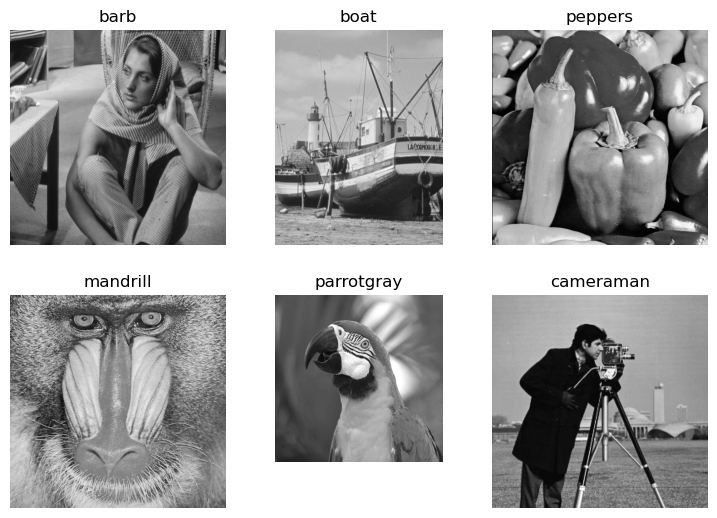

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )
for ax, name in zip(grid, ['barb', 'boat', 'peppers', 'mandrill', 'parrotgray', 'cameraman']):
    img = plt.imread(f"img/{name}.png")
    if img.ndim > 2:
        img = img[..., 0]
    # Iterating over the grid returns the Axes.
    ax.imshow(img, cmap="gray")
    ax.set_title(name)
    ax.axis('off')

plt.show()

# TV-ADMM regularization

As a baseline, we will consider an ADMM algorithm leveraging a TV regularization of the problem (see tutorial 1), i.e., using $g = \lambda TV(\cdot)$ for $\lambda > 0$.

1. Starting from tutorial 1, complete the [`src/mlsp/model/discrete_gradient.py`](src/mlsp/model/discrete_gradient.py) module to implement the discrete gradient operator and its adjoint. Write a short unit-test to verify the correctness of the implementation of the adjoint operator.

2. Complete the files [`src/mlsp/model/cvx_functions.py`](src/mlsp/model/cvx_functions.py) and [`src/mlsp/model/prox.py`](src/mlsp/model/prox.py) to implement all the building blocks related to the TV regularization involved in the TV-ADMM algorithm.

3. Using tutorial 1, indicate a possible splitting approach to ensure the update steps of the ADMM algorithm are simple to compute. Write the general expression of the resulting update steps.

4. Write a simple [`torch`](https://pytorch.org/docs/stable/index.html) implementation of the ADMM algorithm, either as a function or a class, to solve the optimization problem.

In [6]:
# Q1

_test = torch.randint(0, 10, (3, 3))
print(_test)
from mlsp.model.discrete_gradient import gradient_2d
print(gradient_2d(_test))

tensor([[2, 3, 2],
        [3, 2, 3],
        [0, 8, 1]])
tensor([[[ 1., -1.,  1.],
         [-3.,  6., -2.],
         [ 0.,  0.,  0.]],

        [[ 1., -1.,  0.],
         [-1.,  1.,  0.],
         [ 8., -7.,  0.]]])


In [7]:
# Q2



# Loading an existing PnP regularization (denoiser)

- This lab will be based on pre-trained regularization available on github. Read the [`README.md`](README.md) file to retrieve the network weights.

- Once retrieved, an example use for one of the networks is provided below.

In [8]:
from mlsp.model.pnp.network_ffdnet import FFDNet
from mlsp.model.pnp.network_unet import UNetRes

rng = torch.Generator(device="cpu")
rng.manual_seed(1234)

# generating a dummy test image
x0 = torch.normal(0.0, 1.0, (128, 128), generator=rng).to(device)

In [9]:
# loading FFDNet network weights (reference: https://github.com/cszn/KAIR/blob/master/main_test_ffdnet.py)
model_path = "labs/weights/ffdnet_gray.pth"
n_channels = 1  # setting for grayscale image
nc = 64  # setting for grayscale image
nb = 15  # setting for grayscale image
denoiser = FFDNet(in_nc=n_channels, out_nc=n_channels, nc=nc, nb=nb, act_mode="R")
denoiser.load_state_dict(torch.load(model_path), strict=True)
denoiser.eval()
denoiser = denoiser.to(device)

# noise level for the denoiser
noise_level_model = 5.0
sigma = torch.full((1, 1, 1, 1), noise_level_model / 255.0).type_as(x0)

In [10]:
x0.shape, sigma.shape

(torch.Size([128, 128]), torch.Size([1, 1, 1, 1]))

In [11]:
# applying the network (applies by defaut to multiple images in a multi-channel setting, Ni x C x Nx x Ny, with Ni = C = 1 in our case)
x_denoised = torch.squeeze(denoiser(x0[None, None, ...], sigma))
x_denoised.shape

torch.Size([128, 128])

# PnP-ADMM

The plug-and-play (PnP) approach relies on the use of a pre-trained denoiser, encoded in this lab by a neural network. We will mostly use pre-trained networks provided [online on github](https://github.com/cszn/KAIR), see example above.

1. Recall the form of the ADMM and PnP-ADMM algorithms instantiated for the problem considered, expressed in terms a generic denoiser $D_\sigma$, with $\sigma > 0$.

2. Write a simple [`torch`](https://pytorch.org/docs/stable/index.html) implementation of the PnP-ADMM algorithm.
> Hint: 
> - make sure the evolution of the cost function is returned to monitor the behaviour of the algorithm.

## Your answers

1. <p style="color:rgb(137, 207, 240);">Your answer</p>

In [12]:
from mlsp.utils.lab_utils import load_and_normalize_image, generate_2d_cs_data

In [25]:
x = load_and_normalize_image(
    "img/barb.png", device, max_intensity=None, downsampling=4
)
print("Image size: {}".format(x.shape))

isnr = 30
rng = torch.Generator(device="cpu")
rng.manual_seed(1234)

percent = 0.6
observations, sensing_operator, sig, clean_observations = generate_2d_cs_data(x, percent, isnr, rng)

print("Image size: {}".format(x.shape))
print("Number of observations: {}".format(sensing_operator.data_size))

Image size: torch.Size([128, 128])
Image size: torch.Size([128, 128])
Number of observations: torch.Size([4992])


In [27]:
nstep = 1000
x_k = x.clone()
z_k = x_k.clone()
u_k = torch.zeros_like(x)

$\textrm{prox}_{\ell_{2,1}}$ is computed using the property of proximal operator of seperable functions (here with respect to the columns) we deduce the resulting closed form in the ```prox.py``` file.

In [22]:
from mlsp.model.prox import prox_l21norm

with torch.no_grad():
    for i in range(nstep):
        x_k = prox_l21norm((z_k - u_k), 1.0).to(device)
        z_k = denoiser((x_k + u_k)[None, None, ...], sigma).squeeze()
        u_k = u_k+x_k-z_k
        ssim_val = ssim(x.cpu().numpy(), x_k.cpu().numpy(), data_range=1.0)
        # x_k = x.clone()
        print(f"Step {i+1}/{nstep}, SSIM: {ssim_val:.4f}", end="\r")

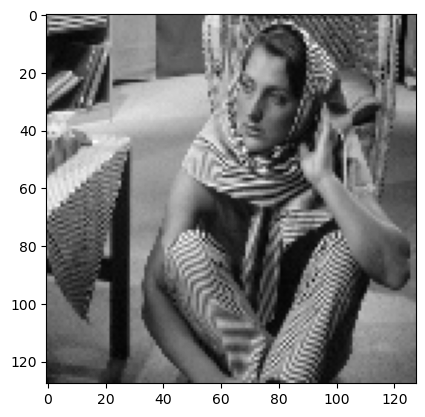

In [28]:
plt.imshow(x.cpu().numpy(), cmap="gray")

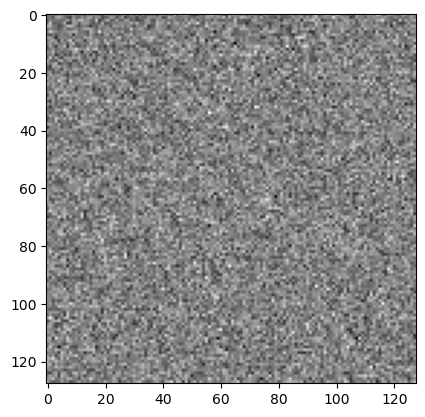

In [24]:
plt.imshow(x0.cpu().numpy(), cmap="gray")

# Results and comparisons

1. 
   1. Recall the definition of the reconstruction signal to noise ratio (rSNR). 
   
   2. Which limitation do you see with this criterion when it comes to assessing the reconstruction of low-amplitude coefficients in the unknown parameter? Is this criterion enough to fully assess the performance of an algorithm.
   
   3. Implement a `torch` function to compte the rSNR.

2. Visually compare the results obtained with the TV-ADMM and PnP-ADMM algorithms, as well as the evolution of the cost function over the iterations.

3. Evaluate the reconstruction performance in terms of rSNR and structural similarity index ([SSIM](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html))

4. Conclude on the performance of these approaches. Identify some of their limits.

## Your answers

1. 
   1. <p style="color:rgb(137, 207, 240);">Your answer</p>

   2. <p style="color:rgb(137, 207, 240);">Your answer</p>

   3. <p style="color:rgb(137, 207, 240);">Your answer</p>

2. <p style="color:rgb(137, 207, 240);">Your answer</p>
3. <p style="color:rgb(137, 207, 240);">Your answer</p>
4. <p style="color:rgb(137, 207, 240);">Your answer</p>

In [ ]:
# your code (mostly call to functions you need to implement in a Python module)

# Bonus: implementation using the `deepinv` library

The [`deepinv`](https://github.com/deepinv/deepinv) library offers a pre-defined set of algorithms and modeling blocks to solve inverse problems with PnP priors.

1. Take a look at the [documentation](https://deepinv.github.io/deepinv/index.html) and the [provided examples](https://deepinv.github.io/deepinv/auto_examples/plug-and-play/demo_PnP_DPIR_deblur.html#sphx-glr-auto-examples-plug-and-play-demo-pnp-dpir-deblur-py). Use one of the optimization algorithms available in the library for comparison with the PnP-ADMM algorithm implemented above.

2. Compare the results obtained to those of your implementation in terms of reconstruction performance and timing.

> Hints:
> - Take a look at the [tutorial example](https://deepinv.github.io/deepinv/auto_examples/plug-and-play/demo_PnP_custom_optim.html#sphx-glr-auto-examples-plug-and-play-demo-pnp-custom-optim-py) to see how to combine the different ingredients made available in the library.

In [ ]:
# your code (mostly call to functions you need to implement in a Python module)